In [0]:
!wget 'http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2'
!ls -lA
!tar xjf RML2016.10b.tar.bz2

--2020-05-11 18:23:30--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  7.25MB/s    in 3m 8s   

2020-05-11 18:26:38 (6.30 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]

total 1216428
drwxr-xr-x 1 root root       4096 May  8 16:16 .config
-rw-r--r-- 1 root root 1245608913 Jun 26  2018 RML2016.10b.tar.bz2
drwxr-xr-x 1 root root       4096 May  4 16:26 sample_data


In [0]:
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import pandas
from copy import deepcopy
import _pickle as cPickle
import gc
from scipy import integrate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
def readData():
    filename = 'RML2016.10b.dat'
    open_file = open(filename,'rb')
    data = cPickle.load(open_file, encoding='latin1')
    keys_list = list(data.keys())
    temp_list = []
    label_list = []
    for i in range(len(keys_list)):
        curr_item = data[keys_list[i]] 
        temp_list.append(curr_item)
        for j in range(curr_item.shape[0]):
            label_list.append(keys_list[i])
            
    # Convert all lists into numpy arrays.
    X = np.array(temp_list).reshape(1200000, 2 , 128)
    Y = np.array(label_list).reshape(1200000, 2)
    snr_int = [int(x) for x in Y[:, 1]]
    ind = np.argsort(snr_int)
    Y = Y[ind]
    X = X[ind]
    X = np.reshape(X,(20,60000,2,1,128))
    return X, Y

X, Y = readData()

In [0]:
X_der = np.gradient(X, axis=0)
X_int = integrate.cumtrapz(X, initial=0)
X_comb = np.concatenate((X, X_der, X_int),axis=2)

In [0]:
def train_test_splitting(X,Y):
  X_train = []
  X_val = []
  X_test = []
  Y_train_enc = []
  Y_train_bin = []
  Y_test_enc = []
  Y_test_bin = []
  Y_val_enc = []
  Y_val_bin= []

  for i in range(X.shape[0]):
    X_curr = X[i]
    Y_curr = Y[i * 60000 : (i + 1) * 60000][:,0]

    le = LabelEncoder()
    le.fit(Y_curr)
    lb = LabelBinarizer()
    lb.fit(Y_curr)
    #Y_curr = le.transform(Y_curr)
    
    X_trainnow, X_testnow, Y_trainnow, Y_testnow = train_test_split(X_curr, Y_curr, test_size=0.3)
    X_trainnow, X_valnow, Y_trainnow, Y_valnow = train_test_split(X_trainnow, Y_trainnow, test_size=0.05)

    Y_trainnow_enc = le.transform(Y_trainnow)
    Y_trainnow_bin = lb.transform(Y_trainnow)

    Y_valnow_enc = le.transform(Y_valnow)
    Y_valnow_bin = lb.transform(Y_valnow)

    Y_testnow_enc = le.transform(Y_testnow)
    Y_testnow_bin = lb.transform(Y_testnow)
    

    X_train.append(X_trainnow)
    X_val.append(X_valnow)
    X_test.append(X_testnow)
    Y_test_enc.append(Y_testnow_enc)
    Y_val_enc.append(Y_valnow_enc)
    Y_train_enc.append(Y_trainnow_enc)
    Y_test_bin.append(Y_testnow_bin)
    Y_val_bin.append(Y_valnow_bin)
    Y_train_bin.append(Y_trainnow_bin)
    
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  X_val = np.array(X_val)
  Y_test_enc = np.array(Y_test_enc)
  Y_val_enc = np.array(Y_val_enc)
  Y_train_enc = np.array(Y_train_enc)
  Y_test_bin = np.array(Y_test_bin)
  Y_val_bin = np.array(Y_val_bin)
  Y_train_bin = np.array(Y_train_bin)
  return X_train , Y_train_enc , Y_train_bin , X_val , Y_val_enc , Y_val_bin , X_test , Y_test_enc , Y_test_bin


X_train , Y_train_enc , Y_train_bin , X_val , Y_val_enc , Y_val_bin , X_test , Y_test_enc , Y_test_bin = train_test_splitting(X_comb,Y)

for arr in [X_train , Y_train_enc , Y_train_bin , X_val , Y_val_enc , Y_val_bin , X_test , Y_test_enc , Y_test_bin]:
  print(arr.shape)

# 20, 39900, 6, 1 , 128
# 20  39900, 1

(20, 39900, 6, 1, 128)
(20, 39900)
(20, 39900, 10)
(20, 2100, 6, 1, 128)
(20, 2100)
(20, 2100, 10)
(20, 18000, 6, 1, 128)
(20, 18000)
(20, 18000, 10)


In [0]:
def logistic_regression(X_train,Y_train,X_val,Y_val,X_test , Y_test):
  clf = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=10000)
  clf.fit(X_train.reshape((X_train.shape[0], -1)),Y_train)
  acc_train = clf.score(X_train.reshape((X_train.shape[0], -1)), Y_train)
  acc_val =  clf.score(X_val.reshape((X_val.shape[0], -1)), Y_val)
  acc_test =  clf.score(X_test.reshape((X_test.shape[0], -1)), Y_test)
  return acc_train ,acc_val ,acc_test

In [0]:
def decision_tree(X_train,Y_train,X_val,Y_val,X_test , Y_test):
  tree = DecisionTreeClassifier()
  tree.fit(X_train.reshape((X_train.shape[0], -1)),Y_train)
  acc_train = tree.score(X_train.reshape((X_train.shape[0], -1)), Y_train)
  acc_val =  tree.score(X_val.reshape((X_val.shape[0], -1)), Y_val)
  acc_test =  tree.score(X_test.reshape((X_test.shape[0], -1)), Y_test)
  return acc_train ,acc_val ,acc_test

In [0]:
def random_forest(X_train,Y_train,X_val,Y_val,X_test , Y_test):
  rf = RandomForestClassifier()
  rf.fit(X_train.reshape((X_train.shape[0], -1)),Y_train)
  acc_train = rf.score(X_train.reshape((X_train.shape[0], -1)), Y_train)
  acc_val =  rf.score(X_val.reshape((X_val.shape[0], -1)), Y_val)
  acc_test =  rf.score(X_test.reshape((X_test.shape[0], -1)), Y_test)
  return acc_train ,acc_val ,acc_test

In [0]:
def dense(X_train,Y_train,X_val,Y_val,X_test , Y_test):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(128, activation="relu", name="dense0"))
  model.add(Dense(10, activation="softmax", name="dense"))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  history = model.fit(X_train, Y_train,validation_data=(X_val,Y_val), epochs = 250, batch_size = 256,callbacks=[callback])
  results = model.evaluate(x=X_test, y=Y_test)
  return history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1] , results[1]

In [0]:
def conv_layers():
    dropoutrate = 0.3    
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(1, 3), name="firstConvLayer", 
                     padding="same", data_format="channels_first", 
                     input_shape=(6,1,128)))
    model.add(BatchNormalization(axis=1, epsilon=0.0001, name='batchnormalization_1'))
    model.add(Activation(activation="relu", name="firstRelu"))
    model.add(Dropout(rate=dropoutrate, name="dropout1"))
    
    model.add(Conv2D(filters=16, kernel_size=(2, 3), data_format="channels_first", padding="same", name="secConvLayer"))
    model.add(BatchNormalization(axis=1, epsilon=0.0001, name='batchnormalization_2'))
    model.add(Activation(activation="relu", name="secRelu"))
    model.add(Dropout(rate=dropoutrate, name="dropout2"))
    
    model.add(Flatten())

    model.add(Dense(128, activation="relu", name="denselayer1"))
    model.add(Dropout(rate=dropoutrate, name="dropout3"))
    model.add(Dense(10, activation="softmax", name="denselayer2"))
    return model

def CNN(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    checkpoint_filepath = '/tmp/checkpoint'
    model = conv_layers()
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_categorical_accuracy',
                                            mode='max',
                                            save_best_only=True)

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 250, batch_size = 512, callbacks=[model_checkpoint_callback])
    
    model.load_weights(checkpoint_filepath)
    results = model.evaluate(x=X_test, y=Y_test)
    return history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1] , results[1]

In [0]:
def call_model(function, X_train, Y_train, X_val, Y_val, X_test, Y_test, startRange=0, endRange=20):
  accuracies_train = []
  accuracies_test = []
  accuracies_val = []
  for i in range(startRange, endRange):
    print(i)
    acc_train , acc_val , acc_test = function(X_train[i],Y_train[i],X_val[i],Y_val[i],X_test[i] , Y_test[i] )
    accuracies_train.append(acc_train)
    accuracies_val.append(acc_val)
    accuracies_test.append(acc_test)
  return np.array(accuracies_train) ,np.array(accuracies_val) ,np.array(accuracies_test) 

# accuracies_decisionTree_train,accuracies_decisionTree_val , accuracies_decisionTree_test = call_model(decision_tree,X_train,Y_train_enc,X_val,Y_val_enc,X_test,Y_test_enc)
# np.save('/content/drive/My Drive/Pattern/accuracies_decisionTree_train.npy',accuracies_decisionTree_train)
# np.save('/content/drive/My Drive/Pattern/accuracies_decisionTree_val.npy',accuracies_decisionTree_val)
# np.save('/content/drive/My Drive/Pattern/accuracies_decisionTree_test.npy',accuracies_decisionTree_test)
# print('decision_tree Done')
# accuracies_logisticRegression_train,accuracies_logisticRegression_val , accuracies_logisticRegression_test = call_model(logistic_regression,X_train,Y_train_enc,X_val,Y_val_enc,X_test,Y_test_enc)
# np.save('/content/drive/My Drive/Pattern/accuracies_logisticRegression_train.npy',accuracies_logisticRegression_train)
# np.save('/content/drive/My Drive/Pattern/accuracies_logisticRegression_val.npy',accuracies_logisticRegression_test)
# np.save('/content/drive/My Drive/Pattern/accuracies_logisticRegression_test.npy',accuracies_logisticRegression_test)
# print('logistic_regression Done')
# accuracies_randomForest_train,accuracies_randomForest_val , accuracies_randomForest_test = call_model(random_forest,X_train,Y_train_enc,X_val,Y_val_enc,X_test,Y_test_enc)
# np.save('/content/drive/My Drive/Pattern/accuracies_randomForest_train.npy',accuracies_randomForest_train)
# np.save('/content/drive/My Drive/Pattern/accuracies_randomForest_val.npy',accuracies_randomForest_val)
# np.save('/content/drive/My Drive/Pattern/accuracies_randomForest_test.npy',accuracies_randomForest_test)
# print('random_forest Done')
# accuracies_dense_train,accuracies_dense_val , accuracies_dense_test  = call_model(dense,X_train,Y_train_bin,X_val,Y_val_bin,X_test , Y_test_bin )
# np.save('/content/drive/My Drive/Pattern/accuracies_dense_train.npy',accuracies_dense_train)
# np.save('/content/drive/My Drive/Pattern/accuracies_dense_val.npy',accuracies_dense_val)
# np.save('/content/drive/My Drive/Pattern/accuracies_dense_test.npy',accuracies_dense_test)
# print('dense Done')

accuracies_cnn_train,accuracies_cnn_val , accuracies_cnn_test  = call_model(CNN, X_train, Y_train_bin, X_val, Y_val_bin, X_test, Y_test_bin)
# np.save('/content/drive/My Drive/Pattern/accuracies_cnn_train.npy', accuracies_cnn_train)
# np.save('/content/drive/My Drive/Pattern/accuracies_cnn_val.npy', accuracies_cnn_val)
# np.save('/content/drive/My Drive/Pattern/accuracies_cnn_test.npy', accuracies_cnn_test)


Streaming output truncated to the last 5000 lines.
Epoch 11/250
78/78 [==============================] - 1s 7ms/step - loss: 0.9545 - categorical_accuracy: 0.5669 - val_loss: 7.2476 - val_categorical_accuracy: 0.1995
Epoch 12/250
78/78 [==============================] - 1s 7ms/step - loss: 0.8812 - categorical_accuracy: 0.6076 - val_loss: 9.3713 - val_categorical_accuracy: 0.2014
Epoch 13/250
78/78 [==============================] - 1s 7ms/step - loss: 0.8283 - categorical_accuracy: 0.6267 - val_loss: 29.6829 - val_categorical_accuracy: 0.0967
Epoch 14/250
78/78 [==============================] - 1s 7ms/step - loss: 0.7886 - categorical_accuracy: 0.6464 - val_loss: 14.4273 - val_categorical_accuracy: 0.1362
Epoch 15/250
78/78 [==============================] - 1s 7ms/step - loss: 0.7554 - categorical_accuracy: 0.6646 - val_loss: 1.5082 - val_categorical_accuracy: 0.5062
Epoch 16/250
78/78 [==============================] - 1s 7ms/step - loss: 0.7214 - categorical_accuracy: 0.6747 - val

In [0]:
# accuracies_decisionTree_test = np.load('/content/drive/My Drive/Pattern/accuracies_decisionTree_test.npy')
# accuracies_logisticRegression_test = np.load('/content/drive/My Drive/Pattern/accuracies_logisticRegression_test.npy')
# accuracies_dense_test = np.load('/content/drive/My Drive/Pattern/accuracies_dense_test.npy')
# accuracies_randomForest_test = np.load('/content/drive/My Drive/Pattern/accuracies_randomForest_test.npy')
# accuracies_cnn_test = np.load('/content/drive/My Drive/Pattern/accuracies_cnn_test.npy')

# accuracies_decisionTree_train = np.load('/content/drive/My Drive/Pattern/accuracies_decisionTree_train.npy')
# accuracies_logisticRegression_train = np.load('/content/drive/My Drive/Pattern/accuracies_logisticRegression_train.npy')
# accuracies_dense_train = np.load('/content/drive/My Drive/Pattern/accuracies_dense_train.npy')
# accuracies_randomForest_train = np.load('/content/drive/My Drive/Pattern/accuracies_randomForest_train.npy')
# accuracies_cnn_train = np.load('/content/drive/My Drive/Pattern/accuracies_cnn_train.npy')

# accuracies_decisionTree_val = np.load('/content/drive/My Drive/Pattern/accuracies_decisionTree_val.npy')
# accuracies_logisticRegression_val  = np.load('/content/drive/My Drive/Pattern/accuracies_logisticRegression_val.npy')
# accuracies_dense_val  = np.load('/content/drive/My Drive/Pattern/accuracies_dense_val.npy')
# accuracies_randomForest_val  = np.load('/content/drive/My Drive/Pattern/accuracies_randomForest_val.npy')
# accuracies_cnn_val  = np.load('/content/drive/My Drive/Pattern/accuracies_cnn_val.npy')

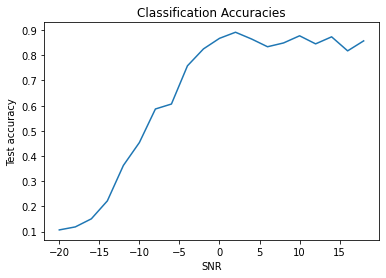

In [0]:
SNR = np.array([i for i in range(-20, 19, 2)])

# plt.plot(SNR,accuracies_dense_test)
# plt.plot(SNR,accuracies_decisionTree_test)
# plt.plot(SNR,accuracies_randomForest_test)
# plt.plot(SNR,accuracies_logisticRegression_test)
plt.plot(SNR, accuracies_cnn_test)
plt.xlabel('SNR')
plt.ylabel('Test accuracy')
plt.title('Classification Accuracies')
# plt.legend(['Dense', 'Decision Tree', 'Random Forest','Logistic Regression','CNN'], loc='upper left')

plt.show()